In [1]:
x=1

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

In [3]:
patient = 'sample'
condition = 'condition'
n_splits = 3

In [4]:
adata = sc.read('/lustre/groups/ml01/projects/2022_multigrate_anastasia.litinetskaya/snakemake/pbmc/3fold/data/pp/rna_hvg_squished.h5ad')
adata

AnnData object with n_obs × n_vars = 588260 × 2000
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'condition', 'sample', 'batch', 'split0', 'split1', 'split2'
    var: 'feature_types', 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'counts'

In [5]:
adata.X.data

array([ 6., 26.,  2., ...,  4.,  2., 10.], dtype=float32)

In [6]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [7]:
rename_dict = {
    "Healthy": 0,
    "Mild": 1,
    "Severe": 2,
}

# NN

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from math import ceil
from sklearn.preprocessing import label_binarize

In [9]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


In [10]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_out(x)
        
        return x

In [11]:
EPOCHS = 30
BATCH_SIZE = 512
LEARNING_RATE = 0.0001
NUM_FEATURES = len(adata.var_names)
NUM_CLASSES = len(adata.obs[condition].cat.categories)

In [12]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

Split 0...
Train shape = ((484206, 2000), (484206,)).
Val shape = ((104054, 2000), (104054,)).
Begin training.


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 030: | Train Loss: 0.07016 | Val Loss: 0.22881 | Train Acc: 97.892| Val Acc: 92.251
class report
              precision    recall  f1-score        support
0              0.373825  0.819681  0.513474   30313.000000
1              0.646778  0.366553  0.467919   53141.000000
2              0.374297  0.135728  0.199216   20600.000000
accuracy       0.452861  0.452861  0.452861       0.452861
macro avg      0.464966  0.440654  0.393536  104054.000000
weighted avg   0.513317  0.452861  0.427994  104054.000000
Accuracy on the test set = 0.4528610144732543.
Split 1...
Train shape = ((178967, 2000), (178967,)).
Val shape = ((409293, 2000), (409293,)).
Begin training.


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 030: | Train Loss: 0.08635 | Val Loss: 0.24774 | Train Acc: 98.036| Val Acc: 90.968
class report
              precision    recall  f1-score        support
0              0.536016  0.141390  0.223757   64262.000000
1              0.629457  0.652255  0.640653  238442.000000
2              0.305003  0.415671  0.351840  106589.000000
accuracy       0.510434  0.510434  0.510434       0.510434
macro avg      0.490159  0.403105  0.405417  409293.000000
weighted avg   0.530291  0.510434  0.499984  409293.000000
Accuracy on the test set = 0.510433845680234.
Split 2...
Train shape = ((513347, 2000), (513347,)).
Val shape = ((74913, 2000), (74913,)).
Begin training.


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 030: | Train Loss: 0.10671 | Val Loss: 0.30800 | Train Acc: 96.401| Val Acc: 88.877
class report
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000      0.000000
1              0.571250  0.584832  0.577961  42985.000000
2              0.463607  0.309415  0.371133  31928.000000
accuracy       0.467449  0.467449  0.467449      0.467449
macro avg      0.344952  0.298082  0.316365  74913.000000
weighted avg   0.525372  0.467449  0.489811  74913.000000
Accuracy on the test set = 0.46744890739924977.
Mean validation accuracy across 5 CV splits for a NN model = 0.47691458918424606.
Mean validation weighted avg across 5 CV splits for a NN model = 0.47259626538059774.


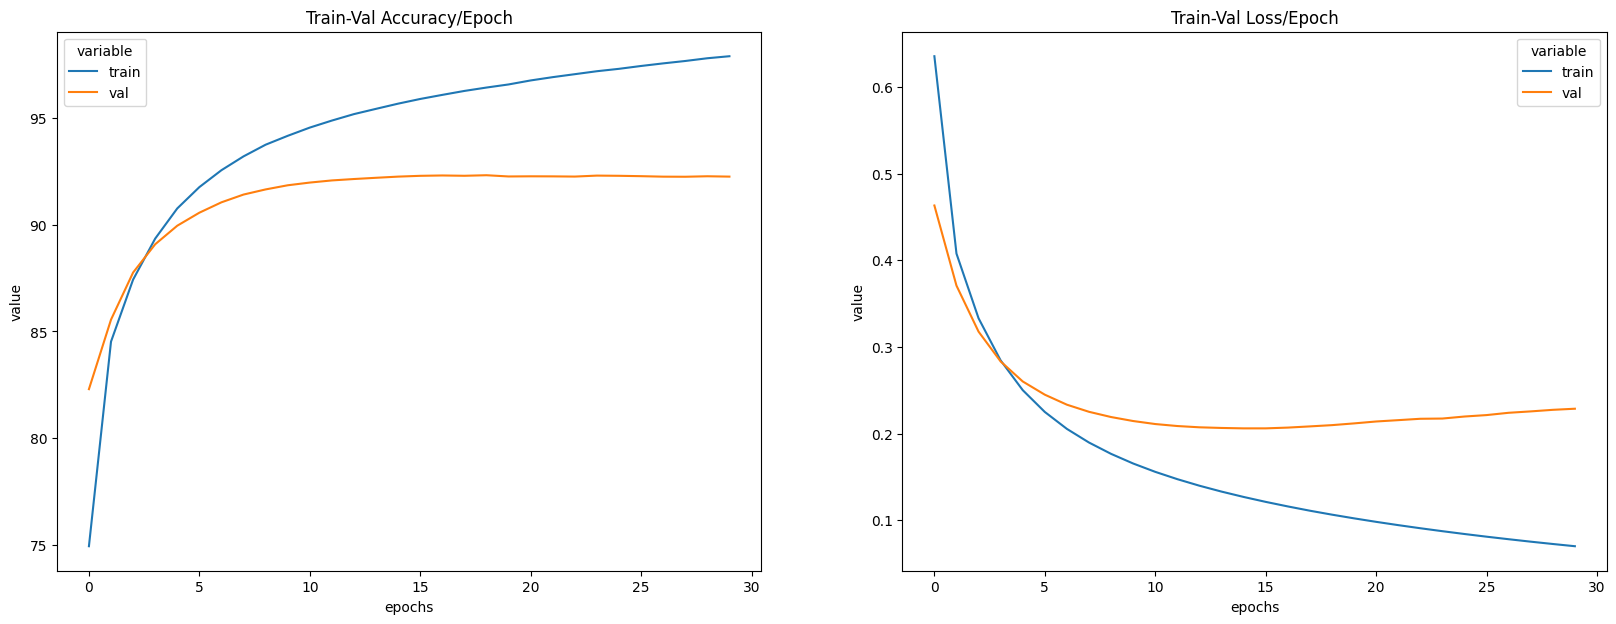

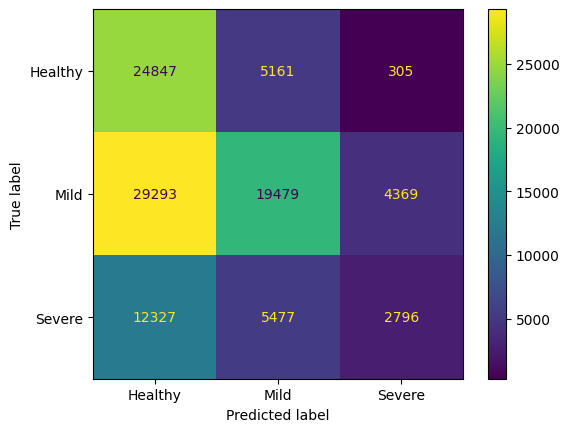

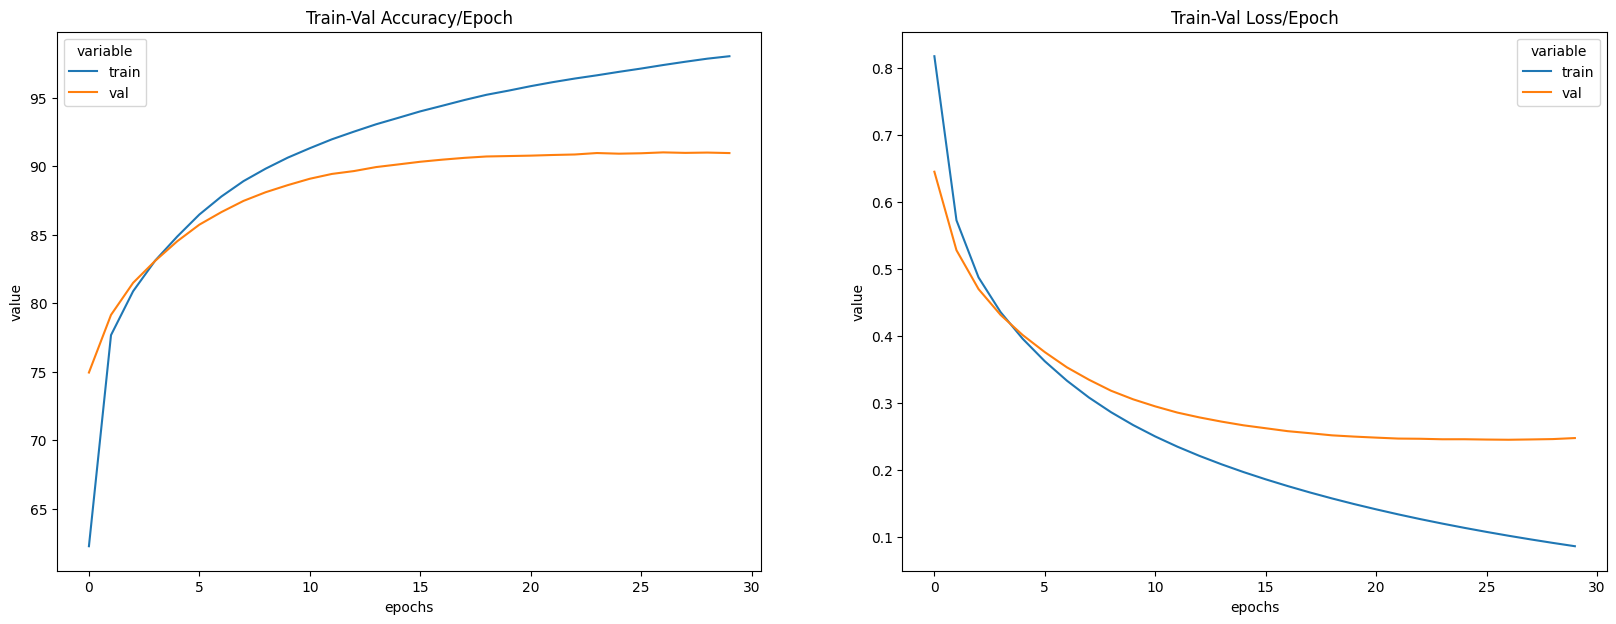

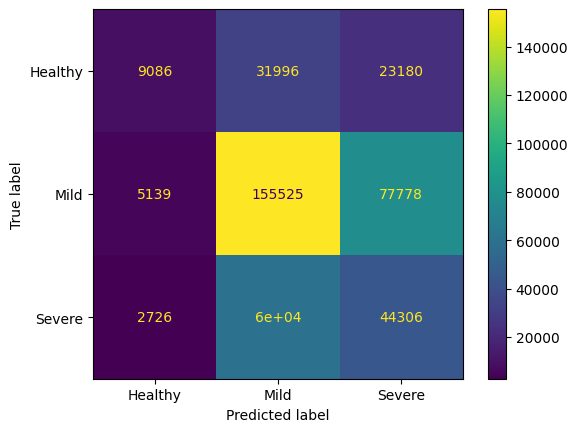

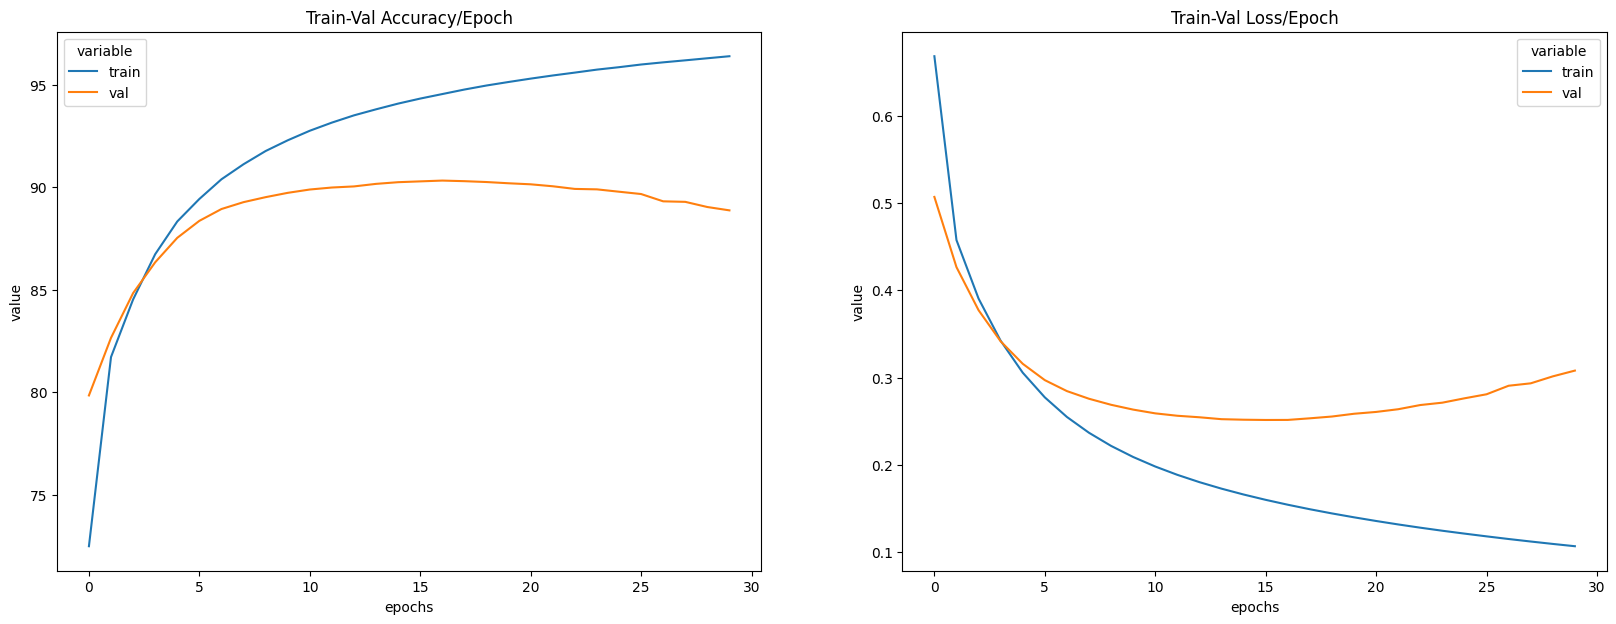

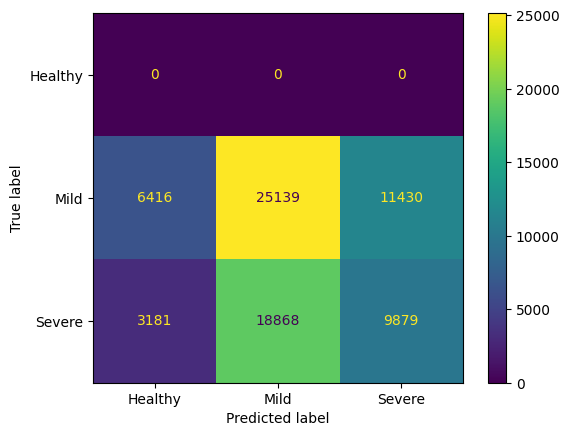

In [13]:
val_accuracies = []
val_avg = []

val_obs_names = {}
val_true = {}
val_predicted = {}

for i in range(n_splits):
    print(f"Split {i}...")
    df = adata.obs[[f'split{i}', patient]].drop_duplicates()
    train = list(df[df[f'split{i}'] == 'train'][patient])
    test = list(df[df[f'split{i}'] == 'val'][patient])
    x = pd.DataFrame(adata[adata.obs[patient].isin(train)].X.A).to_numpy()
    
    
    y = adata[adata.obs[patient].isin(train)].obs[condition].cat.rename_categories(rename_dict)
    y = y.to_numpy()
    print(f'Train shape = ({x.shape}, {y.shape}).')

    x_test = pd.DataFrame(adata[adata.obs[patient].isin(test)].X.A).to_numpy()
    
    y_test = adata[adata.obs[patient].isin(test)].obs[condition].cat.rename_categories(rename_dict)
    y_test = y_test.to_numpy()
    print(f'Val shape = ({x_test.shape}, {y_test.shape}).')

    cut = int(ceil(y.shape[0]*0.8))
    
    X_train = x[:cut]
    y_train = y[:cut]
    
    X_val = x[cut:]
    y_val = y[cut:]
    
    X_test = x_test
    y_test = y_test

    train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
    val_loader = DataLoader(dataset=val_dataset, batch_size=1)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1)

    model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    accuracy_stats = {
        'train': [],
        "val": []
    }
    loss_stats = {
        'train': [],
        "val": []
    }

    print("Begin training.")
    for e in tqdm(range(1, EPOCHS+1)):
        
        # TRAINING
        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch, y_train_batch
            optimizer.zero_grad()
    
            y_train_pred = model(X_train_batch)
    
            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = multi_acc(y_train_pred, y_train_batch)
    
            train_loss.backward()
            optimizer.step()
    
            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()
            
            
        # VALIDATION    
        with torch.no_grad():
            
            val_epoch_loss = 0
            val_epoch_acc = 0
            
            model.eval()
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch, y_val_batch
                
                y_val_pred = model(X_val_batch)
                            
                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = multi_acc(y_val_pred, y_val_batch)
                
                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()
                
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))
        accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
        accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                                  
        
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    
    # Create dataframes
    train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    # Plot the dataframes
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
    sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
    sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

    # predict
    y_pred_list = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in test_loader:
            X_batch = X_batch
            y_test_pred = model(X_batch)
            _, y_pred_tags = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tags.cpu().numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    
    df = classification_report(y_test, y_pred_list, output_dict=True)
    df = pd.DataFrame(df).T
    print('class report')
    print(df)

    val_obs_names[i] = adata[adata.obs[patient].isin(test)].obs_names
    val_true[i] = y_test
    val_predicted[i] = y_pred_list
    
    val_accuracies.append(df["f1-score"]["accuracy"])
    val_avg.append(df["f1-score"]["weighted avg"])
    
    print(f'Accuracy on the test set = {df["f1-score"]["accuracy"]}.')

    cm = confusion_matrix(y_test, y_pred_list)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Mild', 'Severe'])
    disp.plot()
    
    print('===========================')
    
print(f"Mean validation accuracy across 5 CV splits for a NN model = {np.mean(np.array(val_accuracies))}.")
print(f"Mean validation weighted avg across 5 CV splits for a NN model = {np.mean(np.array(val_avg))}.")


In [14]:
for i in range(n_splits):
    df = pd.DataFrame([val_obs_names[i], val_true[i], val_predicted[i]]).T
    df = df.set_index(0)
    df = df.rename(columns={1: 'true', 2: 'predicted'})
    df.to_csv(f'pbmc_gex_nn_baseline_fold{i}.csv')

# Random forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
adata.obs[condition] = adata.obs[condition].astype('category')
rename_dict = {name: number for number, name in enumerate(sorted(list(adata.obs[condition].cat.categories)))}
rename_dict

{'Healthy': 0, 'Mild': 1, 'Severe': 2}

Processing split = 0...
Train shapes:
x.shape = (484206, 2000)
y.shape = (484206,)
Val shapes:
x_val.shape = (104054, 2000)
y_val.shape = (104054,)
Train accuracy = 0.9717454967513827.
class report
              precision    recall  f1-score        support
0              0.401513  0.595124  0.479513   30313.000000
1              0.585289  0.556256  0.570403   53141.000000
2              0.213250  0.089223  0.125809   20600.000000
accuracy       0.475119  0.475119  0.475119       0.475119
macro avg      0.400017  0.413535  0.391908  104054.000000
weighted avg   0.458097  0.475119  0.455907  104054.000000
Val accuracy = 0.4751186883733446.
Processing split = 1...
Train shapes:
x.shape = (178967, 2000)
y.shape = (178967,)
Val shapes:
x_val.shape = (409293, 2000)
y_val.shape = (409293,)
Train accuracy = 0.9696256851821844.
class report
              precision    recall  f1-score        support
0              0.409098  0.232439  0.296446   64262.000000
1              0.611052  0.704293  0.6

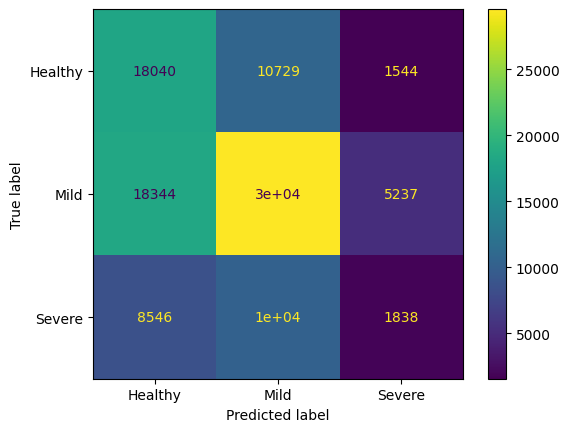

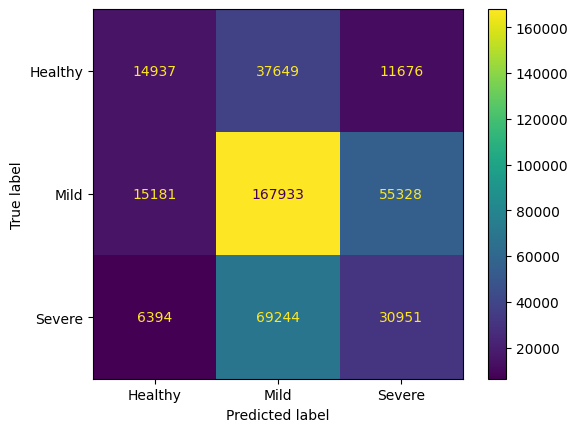

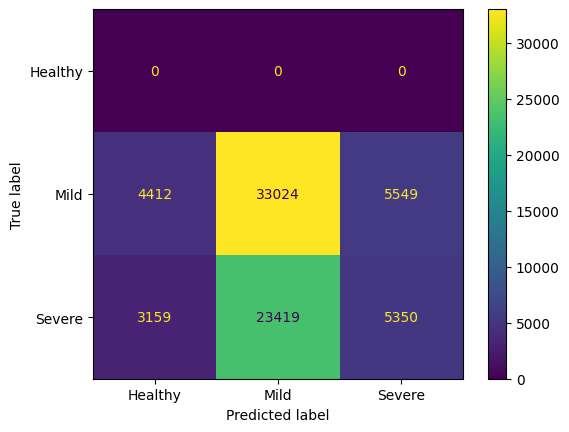

In [18]:
val_accuracies = []
val_avg = []

val_obs_names = {}
val_true = {}
val_predicted = {}

for i in range(n_splits):
    print(f'Processing split = {i}...')
    #df = adata.obs[[f'split{i}', patient]].drop_duplicates()
    #train = list(df[df[f'split{i}'] == 'train'][patient])
    #val = list(df[df[f'split{i}'] == 'val'][patient])
    # train data
    x = pd.DataFrame(adata[adata.obs[f'split{i}'] == 'train'].X.A).to_numpy()
    num_of_classes = len(adata.obs[condition].cat.categories)
    y = adata[adata.obs[f'split{i}'] == 'train'].obs[condition].cat.rename_categories(rename_dict)
    y = y.to_numpy()
    print("Train shapes:")
    print(f"x.shape = {x.shape}")
    print(f"y.shape = {y.shape}")
    # val data
    x_val = pd.DataFrame(adata[adata.obs[f'split{i}'] == 'val'].X.A).to_numpy()
    y_val = adata[adata.obs[f'split{i}'] == 'val'].obs[condition].cat.rename_categories(rename_dict)
    y_val = y_val.to_numpy()
    print("Val shapes:")
    print(f"x_val.shape = {x_val.shape}")
    print(f"y_val.shape = {y_val.shape}")
    # fit
    X = x
    Y = y
    clf = RandomForestClassifier(n_estimators=5)
    clf.fit(X, Y)
    print(f'Train accuracy = {np.sum(clf.predict(X) == Y)/len(Y)}.')
    y_pred = clf.predict(x_val)
    val_accuracy = np.sum(y_pred == y_val)/len(y_val)
    
    df = classification_report(y_val, y_pred, output_dict=True)
    df = pd.DataFrame(df).T
    print('class report')
    print(df)
    
    val_accuracies.append(df["f1-score"]["accuracy"])
    val_avg.append(df["f1-score"]["weighted avg"])
    
    val_accuracy = df["f1-score"]["accuracy"]
    
    print(f'Val accuracy = {val_accuracy}.')

    val_obs_names[i] = adata[adata.obs[f'split{i}'] == 'train'].obs_names
    val_true[i] = y_val
    val_predicted[i] = y_pred
    
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Mild', 'Severe'])
    disp.plot()
    
    print('===========================')


print(f"Mean validation accuracy across 5 CV splits for a random forest model = {np.mean(np.array(val_accuracies))}.")
print(f"Mean validation weighted avg across 5 CV splits for a random forest model = {np.mean(np.array(val_avg))}.")


In [19]:
for i in range(n_splits):
    df = pd.DataFrame([val_obs_names[i], val_true[i], val_predicted[i]]).T
    df = df.set_index(0)
    df = df.rename(columns={1: 'true', 2: 'predicted'})
    df.to_csv(f'pbmc_gex_rf_baseline_fold{i}.csv')